In [31]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

### mobilenet 1

In [11]:
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
classifier_url = url

In [23]:
IMAGE_SHAPE = (224,224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url,input_shape=IMAGE_SHAPE+(3,))
])
classifier.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_12 (KerasLayer)  (None, 1001)             3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


61306/61306 [==============================] - 0s 0us/step


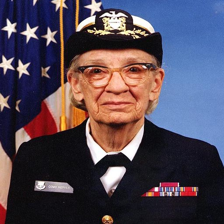

In [24]:
import numpy as np
import PIL.Image as Image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg',url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [25]:
#정규화
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [28]:
#4차원 배열로 만드는 작업 
#np.newaxis = 새로운 차원 추가하기. ... = numpy elipse = 생략기호
#나머지 차원은 그대로 유지하며 차원 추가하기
result = classifier.predict(grace_hopper[np.newaxis,...]) 
result.shape

1/1 [==============================] - 0s 125ms/step


(1, 1001)

653


Text(0.5, 1.0, 'military uniform')

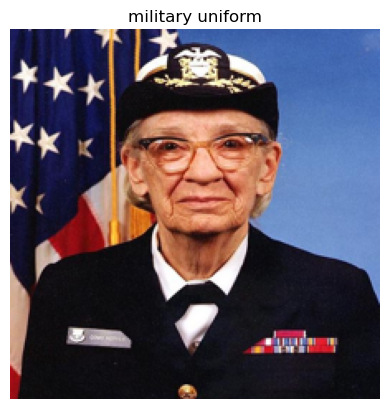

In [33]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#tf.keras.utils.get_file() 함수를 사용하여 url에서 파일을 다운로드하고 캐시 디렉토리에 저장
#함수는 로컬 파일 경로를 반환하며, 이를 label_path 변수에 할당
label_path = tf.keras.utils.get_file('ImageNetLabels.txt',url)
imagenet_labes = np.array(open(label_path).read().splitlines())

#가장 큰 숫자 인덱스 가져오기. = 모바일넷의 653 번쨰 이미지라는 뜻.
predicted_class = np.argmax(result[0],axis=-1)
print(predicted_class)

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labes[predicted_class]
plt.title(predicted_class_name)

### mobilenet 2

In [34]:
data_dir = tf.keras.utils.get_file(
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
    'flower_photos',
    untar=True)

228813984/228813984 [==============================] - 4s 0us/step


In [36]:
#rescale 및 라벨 인식
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_dir),target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [37]:
for image_batch, label_batch in image_data:
    print('Image batch shape : ', image_batch.shape)
    print('Label batch shape : ', label_batch.shape)
    break

Image batch shape :  (32, 224, 224, 3)
Label batch shape :  (32, 5)


#### 미학습 추론

In [38]:
result_batch = classifier.predict(image_batch)
result_batch.shape

1/1 [==============================] - 2s 2s/step


(32, 1001)

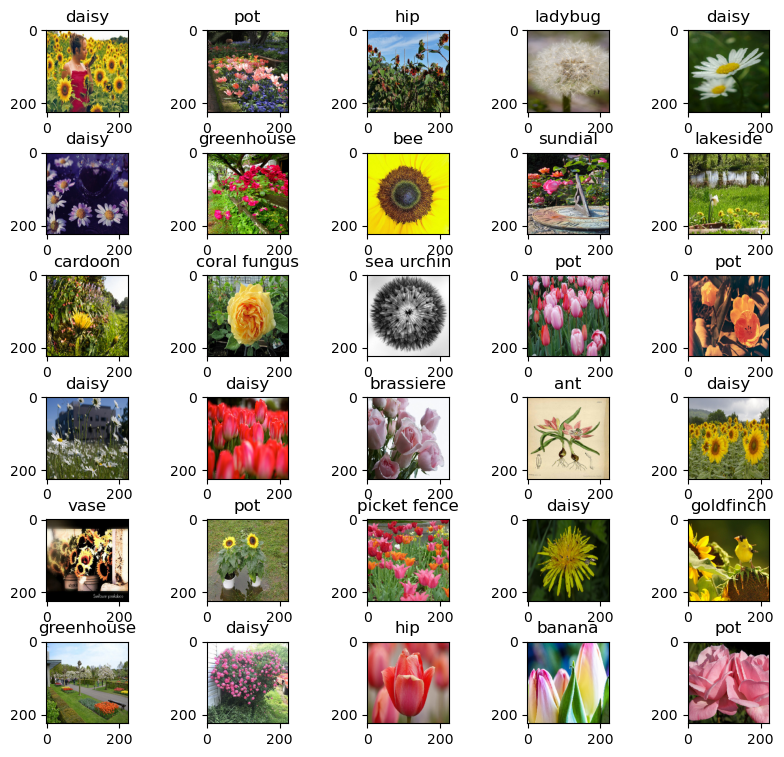

In [44]:
predicted_class_names = imagenet_labes[np.argmax(result_batch,axis=-1)]
len(predicted_class_names)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])

In [46]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [50]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes,activation='softmax') #dense layer 추가
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_13 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [52]:
predictions = model(image_batch)
predictions.shape
#최종 shape 확인

TensorShape([32, 5])

In [54]:
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['acc'])

In [55]:
#callback 정의
#loss, acc 배치별로 뽑는 역할
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_train_batch_end(self,batch,logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [58]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()
history = model.fit_generator(image_data,epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2


/var/folders/7z/944bgjcs659fsp58nc954qgm0000gn/T/ipykernel_25001/3631290632.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data,epochs=2,


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
115/115 [==============================] - 55s 456ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
115/115 [==============================] - 51s 440ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


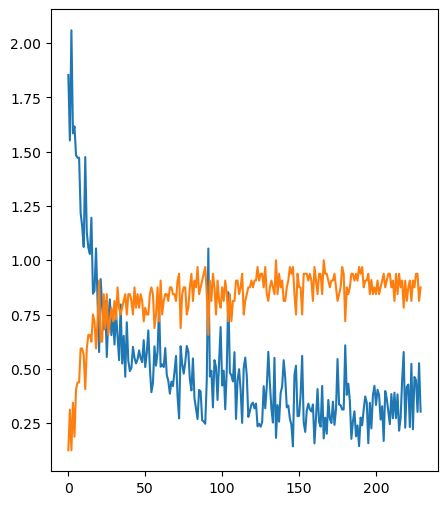

In [62]:
#콜백함수에 들어간 값 plot
plt.figure(figsize=(5,6))
plt.plot(batch_stats_callback.batch_losses)
plt.plot(batch_stats_callback.batch_acc)

In [69]:
#class 이름 할당
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [70]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch,axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step


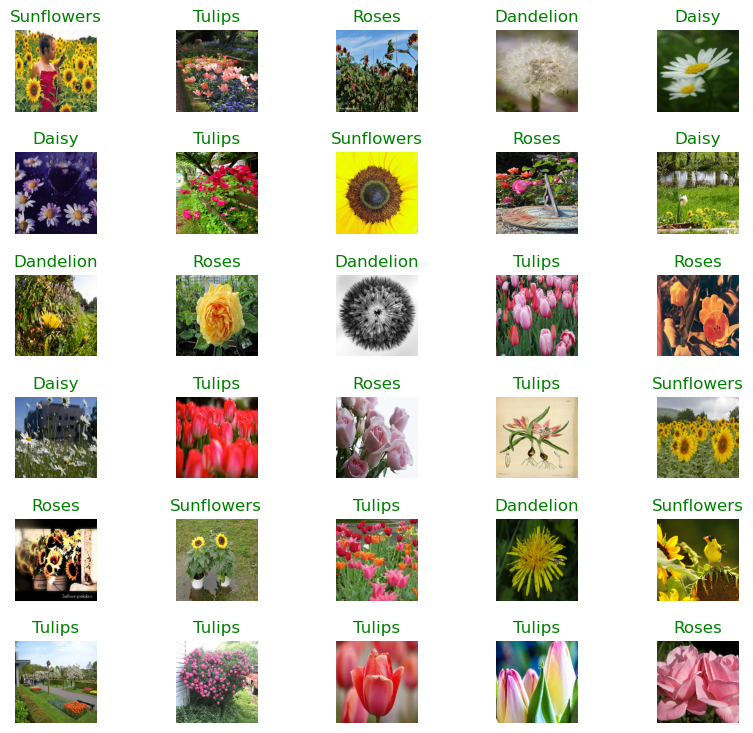

In [77]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(image_batch[i])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[i].title(),color=color)
    plt.axis('off')

In [79]:
model.save('transfer',save_format='tf')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: transfer/assets


INFO:tensorflow:Assets written to: transfer/assets
